In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [2]:
img_size = 256

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Img",
    batch_size = 32,
    image_size = (img_size, img_size),
    shuffle = True
)

Found 2152 files belonging to 3 classes.


In [4]:
# Printing class names, basicaaly folder name called class name
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# Printing length of dataset
len(dataset)

68

Boooom!!!, why it is showing 68, do you have any idea?

Basically we have loaded all images into batches of 32 so 32*68 = total images

Yess, Yes I know last batch is not complete so 32*68 will not come 2152

In [6]:
for batch_image, label_batch in dataset.take(1):
    print(batch_image[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[109., 110., 128.],
        [116., 117., 135.],
        [107., 108., 126.],
        ...,
        [166., 172., 188.],
        [169., 175., 191.],
        [173., 179., 195.]],

       [[121., 122., 140.],
        [122., 123., 141.],
        [116., 117., 135.],
        ...,
        [163., 169., 185.],
        [166., 172., 188.],
        [169., 175., 191.]],

       [[124., 125., 143.],
        [116., 117., 135.],
        [117., 118., 136.],
        ...,
        [160., 166., 182.],
        [163., 169., 185.],
        [165., 171., 187.]],

       ...,

       [[127., 132., 151.],
        [126., 131., 150.],
        [122., 127., 146.],
        ...,
        [164., 171., 190.],
        [156., 163., 182.],
        [171., 178., 197.]],

       [[121., 126., 145.],
        [121., 126., 145.],
        [118., 123., 142.],
        ...,
        [160., 167., 186.],
        [163., 170., 189.],
       

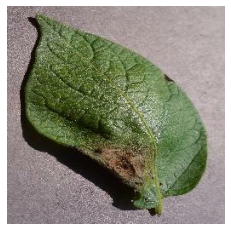

In [7]:
for batch_image, label_batch in dataset.take(1):
    plt.imshow(batch_image[0].numpy().astype('uint8'))
    plt.axis("off")

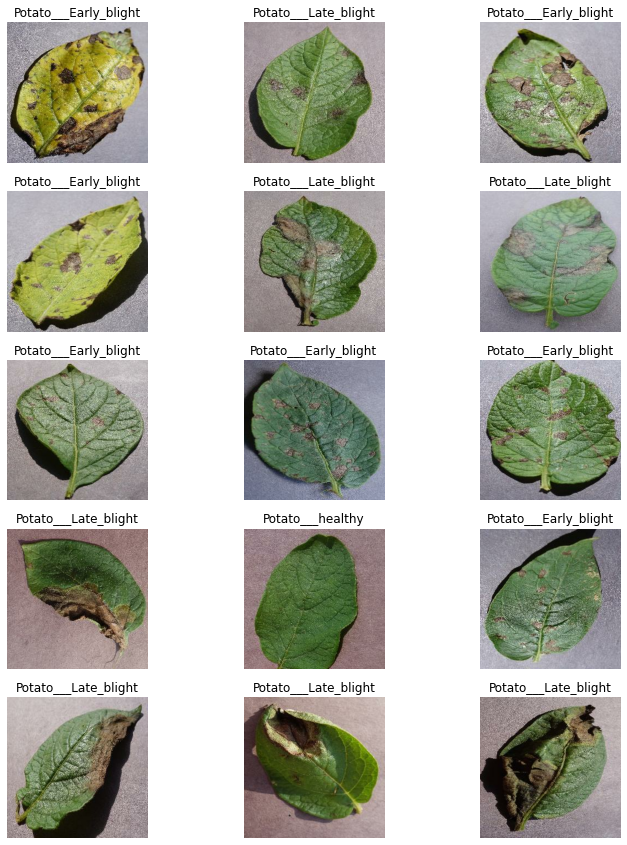

In [8]:
# printing 15 images from batch 1
plt.figure(figsize=(12,15))
for batch_image, label_batch in dataset.take(1):
    for img in range(15):
        plt.subplot(5,3,img+1)
        plt.title(class_names[label_batch[img]])
        plt.imshow(batch_image[img].numpy().astype('uint8'))
        plt.axis("off")

# Spliting Dataset into Train Test and Validation

I am spliting dataset into trainign, testing and validation. I have total 68 batches in my dataset. I am spliting dataset as follows :

Training -> 80%
Testing -> 10%
Validation -> 10%

In [9]:
# Trainng size is 80% so 80% of 68 is approx 54 so I am taking 54 batched for training dataset

train_ds = dataset.take(54)

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
#so now test data set is 14 now I have take 10% from test dataset for validation. It will come approx 6
val_ds = test_ds.take(6)

In [12]:
test_ds = test_ds.skip(6)

In [13]:
# I am creating a function for train Test Split

def get_split_dataset(ds, train_split = 0.8, test_split=0.1, val_split = 0.1, shuffle = True, shuffle_size = 1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(ds_size*train_split)
    train_ds = ds.take(train_size)
    val_size = int(ds_size*val_split)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds
    

In [14]:
train_ds, test_ds, val_ds = get_split_dataset(dataset)

In [15]:
len(val_ds)

6

In [16]:
#Using Cache and prefecth for improving performece of model. It will save timing of loading images while reading the images.

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
# Creating Resizing and Re-scaling Layers. Alothough all images are 256*256 but after model deployement we can receiveddifferent sizes so it will helpful at that time

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(0.1/255)
])

In [18]:
# Creating Data Augmentation to generate random flip and rotated images

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
input_shapes = (32, img_size, img_size, 3)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shapes),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),   
    
])

model.build(input_shape = input_shapes)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer= 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    epochs=10,
    batch_size=32,
    verbose = 1,
    validation_data= val_ds
)

Epoch 1/10
54/54 [==============================] - 457s 8s/step - loss: 0.9219 - accuracy: 0.4410 - val_loss: 1.0670 - val_accuracy: 0.5104
Epoch 2/10
54/54 [==============================] - 427s 8s/step - loss: 0.7914 - accuracy: 0.6406 - val_loss: 0.8497 - val_accuracy: 0.6823
Epoch 3/10
54/54 [==============================] - 329s 6s/step - loss: 0.5349 - accuracy: 0.8073 - val_loss: 0.5177 - val_accuracy: 0.7969
Epoch 4/10
54/54 [==============================] - 388s 7s/step - loss: 0.4480 - accuracy: 0.8287 - val_loss: 0.4287 - val_accuracy: 0.7969
Epoch 5/10
54/54 [==============================] - 386s 7s/step - loss: 0.4453 - accuracy: 0.8160 - val_loss: 0.4258 - val_accuracy: 0.8177
Epoch 6/10
54/54 [==============================] - 410s 7s/step - loss: 0.3419 - accuracy: 0.8767 - val_loss: 0.3316 - val_accuracy: 0.8906
Epoch 7/10
54/54 [==============================] - 459s 9s/step - loss: 0.3132 - accuracy: 0.8860 - val_loss: 0.3994 - val_accuracy: 0.8542
Epoch 8/10
54

In [23]:
score = model.evaluate(test_ds)

8/8 [==============================] - 17s 1s/step - loss: 0.2296 - accuracy: 0.9258


In [24]:
score

[0.22956480085849762, 0.92578125]

In [25]:
history

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
img_size = 256
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato_Img",
    batch_size = 32,
    image_size = (img_size, img_size),
    shuffle = True
)
# Printing class names, basicaaly folder name called class name
class_names = dataset.class_names
class_names
# Printing length of dataset
len(dataset)
for batch_image, label_batch in dataset.take(1):
    print(batch_image[0].numpy)
for batch_image, label_batch in dataset.take(1):
    plt.imshow(batch_image[0].numpy().astype('uint8'))
    plt.axis("off")
# printing 15 images from batch 1
plt.figure(figsize=(12,15))
for batch_image, label_batch in dataset.take(1):
    for img in range(15):
        plt.subplot(5,3,img+1)
        plt.title(class_names[label_batch[img]])
        plt.imshow(batch_image[img].numpy().astype('uint8'))
        plt.axis("off")
# Trainng size is 80% so 80% of 68 is approx 

In [26]:
history.params

NameError: name 'history' is not defined

First Image to Predict : 
First Image Actual Label :  Potato___Late_blight
Predicted Label :  Potato___Late_blight


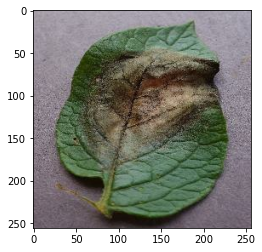

In [35]:
for images_batch, label_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0]
    
    print("First Image to Predict : ")
    plt.imshow(first_image)
    
    print("First Image Actual Label : ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label : ", class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

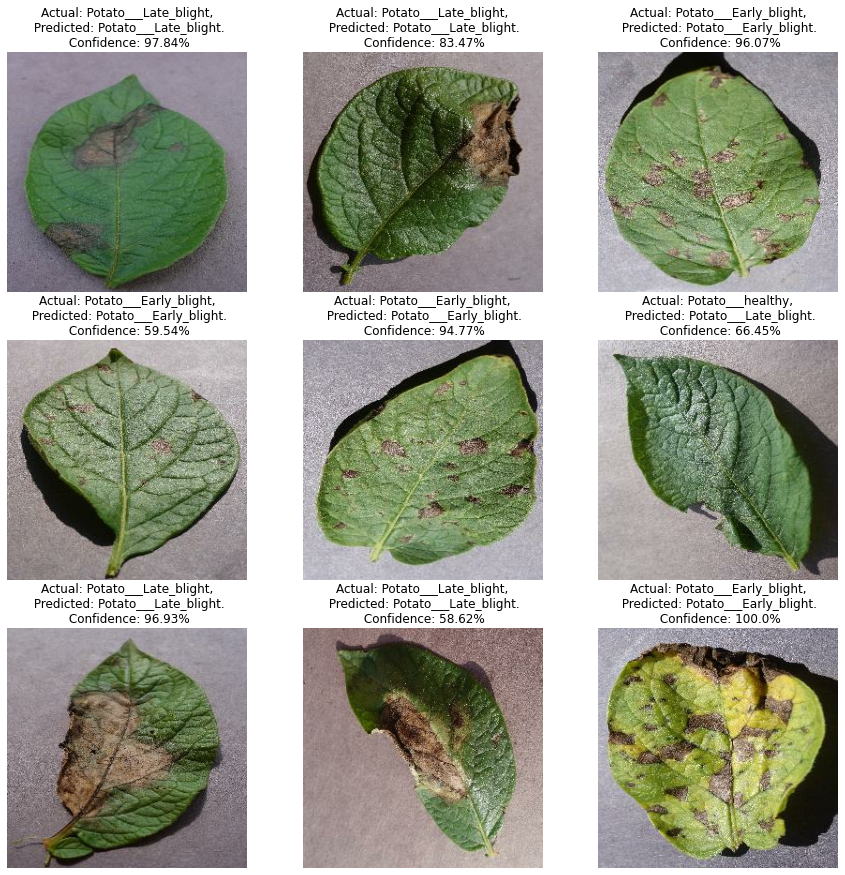

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
model.save("Potato_DisV1.h5")